<!-- .. _providing_valid_inputs: -->
# Providing Valid Inputs

PyProbe uses Pydantic for input validation. This exists to ensure that the data provided
is in the correct format to prevent unexpected errors. Most of the time, this will 
happen behind-the-scenes, so you will only notice it if there is a problem. This 
example is written to demonstrate how these errors may come about.


## RawData Validation
The RawData class is a specific variant of the Result object which only stores data
in the standard PyProBE format. Therefore, validation is performed when a RawData object
is created to verify this. 

If you follow the standard method for importing data into PyProBE, you should never
experience these errors, however it is helpful to know that they exist.

We will start with a normal dataset, printing the type that the procedure data is stored 
in:

In [1]:
import pyprobe
import polars as pl

info_dictionary = {'Name': 'Sample cell',
                   'Chemistry': 'NMC622',
                   'Nominal Capacity [Ah]': 0.04,
                   'Cycler number': 1,
                   'Channel number': 1,}
data_directory = '../../../tests/sample_data/neware'

# Create a cell object
cell = pyprobe.Cell(info=info_dictionary)
cell.add_procedure(procedure_name='Sample',
                   folder_path = data_directory,
                   filename = 'sample_data_neware.parquet')
print(type(cell.procedure['Sample']))

<class 'pyprobe.filters.Procedure'>


The Procedure class inherits from RawData, which has a defined set of required columns
(the PyProBE standard format):

In [2]:
print(pyprobe.rawdata.required_columns)

['Time [s]', 'Step', 'Cycle', 'Event', 'Current [A]', 'Voltage [V]', 'Capacity [Ah]']


Whenever a RawData class (or any of the filters module classes, that inherit from it) are 
created, the dataframe is checked against these required columns. We will create an
example dataframe that is missing columns, which will be identified by the error that is returned.

In [3]:
incorrect_dataframe = pl.DataFrame({'Time [s]': [1, 2, 3],
                                    'Voltage [V]': [3.5, 3.6, 3.7],
                                    'Current [A]': [0.1, 0.2, 0.3],
                                    })
pyprobe.rawdata.RawData(base_dataframe=incorrect_dataframe,
                        info = {})

ValidationError: 1 validation error for RawData
base_dataframe
  Value error, Missing required columns: ['Step', 'Cycle', 'Event', 'Capacity [Ah]'] [type=value_error, input_value=shape: (3, 3)
┌──...───────┘, input_type=DataFrame]
    For further information visit https://errors.pydantic.dev/2.8/v/value_error

You will also see a validation error if you try to create one of these classes with a
data object that is not a Polars DataFrame or LazyFrame:

In [4]:
incorrect_data_dict = {'Time [s]': [1, 2, 3],
                                    'Voltage [V]': [3.5, 3.6, 3.7],
                                    'Current [A]': [0.1, 0.2, 0.3],
                                    }
pyprobe.rawdata.RawData(base_dataframe=incorrect_data_dict,
                        info = {})

ValidationError: 2 validation errors for RawData
base_dataframe.is-instance[LazyFrame]
  Input should be an instance of LazyFrame [type=is_instance_of, input_value={'Time [s]': [1, 2, 3], '...t [A]': [0.1, 0.2, 0.3]}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.8/v/is_instance_of
base_dataframe.is-instance[DataFrame]
  Input should be an instance of DataFrame [type=is_instance_of, input_value={'Time [s]': [1, 2, 3], '...t [A]': [0.1, 0.2, 0.3]}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.8/v/is_instance_of

## Analysis Class Validation

You are much more likely to experience validation errors when dealing with the classes in the 
analysis module. These classes, and the methods within them, may require a particular
PyProBE object to work.

As an example, the Cycling class requires an Experiment input. This is because it 
provides calculations based on the cycle() method of the experiment class:

In [5]:
experiment_object = cell.procedure['Sample'].experiment('Break-in Cycles')
print(type(experiment_object))

<class 'pyprobe.filters.Experiment'>


The experiment object should return no errors:

In [6]:
from pyprobe.analysis.cycling import Cycling
cycling = Cycling(input_data = experiment_object)

However, if I were to filter the object further, I would get an error:

In [7]:
cycling = Cycling(input_data = experiment_object.cycle(1))

ValidationError: 1 validation error for Cycling
input_data
  Input should be a valid dictionary or instance of Experiment [type=model_type, input_value=Cycle(base_dataframe=<Laz...e beginning of cycle.'}), input_type=Cycle]
    For further information visit https://errors.pydantic.dev/2.8/v/model_type

Types and columns are also validated in the methods of analysis classes. You can create a 
DMA object on any pyprobe data type:

In [8]:
pOCV = cell.procedure['Sample'].experiment('Break-in Cycles').cycle(1).discharge(0)

from pyprobe.analysis.degradation_mode_analysis import DMA

But the average_ocvs() method is stricter. It must be provided with a filter no deeper
than Cycle as it requires both a charge and a discharge curve to work on.

In [9]:
averaged_ocv_dma = DMA.average_ocvs(input_data = pOCV)

ValidationError: 1 validation error for AnalysisValidator
  Value error, Input data is not of type typing.Union[pyprobe.filters.Procedure, pyprobe.filters.Experiment, pyprobe.filters.Cycle] [type=value_error, input_value={'input_data': Step(base_... pyprobe.filters.Cycle]}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.8/v/value_error

In [10]:
pOCV_cycle = cell.procedure['Sample'].experiment('Break-in Cycles').cycle(1)
averaged_ocv_dma = DMA.average_ocvs(input_data = pOCV_cycle)

ValidationError: 1 validation error for AnalysisValidator
  Value error, Missing required columns: ['SOC'] [type=value_error, input_value={'input_data': Cycle(base... pyprobe.filters.Cycle]}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.8/v/value_error

We are now told that we are missing an SOC column. This is encouraged to be calculated outside
the module so it is clearer to the user how the curves will align. We can create an
SOC column with the set_SOC() method:

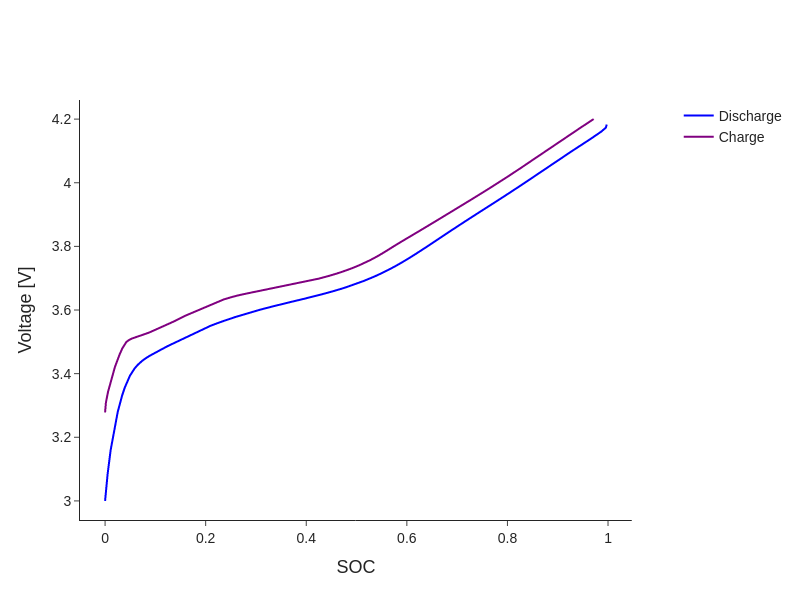

In [11]:
pOCV_cycle.set_SOC()
fig = pyprobe.Plot()
fig.add_line(pOCV_cycle.discharge(0).constant_current(0), x='SOC', y='Voltage [V]', label='Discharge', color='blue')
fig.add_line(pOCV_cycle.charge(0).constant_current(0), x='SOC', y='Voltage [V]', label='Charge', color='purple')
fig.show_image()
# fig.show() # This will show the plot interactively, it is commented out for the sake of the documentation

We can then provide this updated result object to the method:

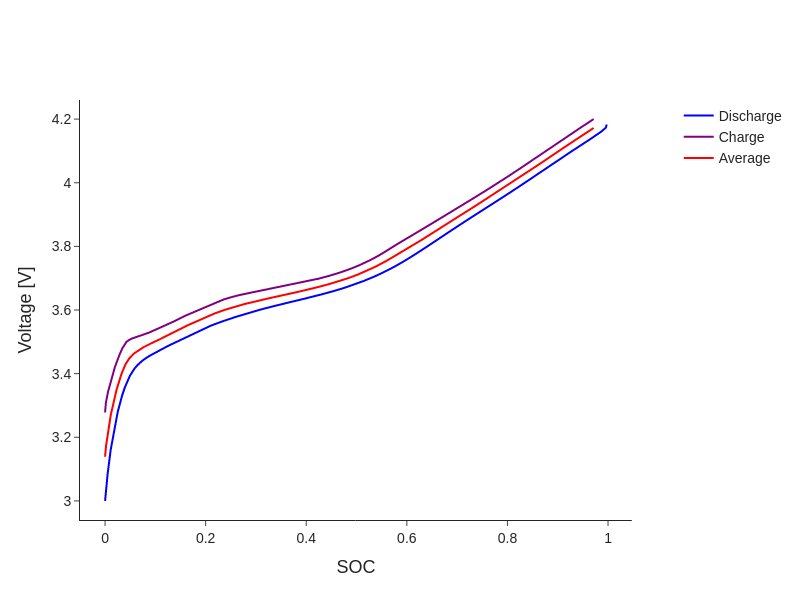

In [12]:
averaged_ocv_dma = DMA.average_ocvs(input_data = pOCV_cycle, charge_filter="charge(0).constant_current(0)", discharge_filter="discharge(0).constant_current(0)")

fig.add_line(averaged_ocv_dma.input_data, x='SOC', y='Voltage [V]', label='Average', color='red')
fig.show_image()
# fig.show() # This will show the plot interactively, it is commented out for the sake of the documentation